In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
pickup_data = pd.read_pickle('arrival_and_dropoff_distributions')
hourly_arrival_rate =  pickup_data.apply(lambda item: item[0])
dropoff_frequency  = pickup_data.apply(lambda  item: item[1] / item[1].sum())
trip_time_data = pd.read_parquet('trip_time_means')
trip_time_data

mean        std        min         max  count
pulocationid                                                        
1            1    19.037500  17.794296   2.716667   55.000000    8.0
             2     0.000000   0.000000   0.000000    0.000000    0.0
             3    54.540476  15.923260  34.650000  100.883333   14.0
             4    34.259722   6.489705  22.533333   85.900000  186.0
             5    25.073516   2.869861  17.350000   43.750000   86.0
...                     ...        ...        ...         ...    ...
105          259   0.000000   0.000000   0.000000    0.000000    0.0
             260   0.000000   0.000000   0.000000    0.000000    0.0
             261   0.000000   0.000000   0.000000    0.000000    0.0
             262   0.000000   0.000000   0.000000    0.000000    0.0
             263   0.000000   0.000000   0.000000    0.000000    0.0

[69169 rows x 5 columns]

In [3]:
from tqdm.notebook import tqdm
from city_elements import *
from city import *
from event_list import *

def generate_arrivals_per_zone(zone_hourly_arrivals = hourly_arrival_rate, 
                               zone_dropoff_frequencies = dropoff_frequency, 
                               zone_to_zone_times = trip_time_data, 
                               one_list = True,
                               show_progress_bar = False):
    
    #check to make sure the indices match
    assert (zone_hourly_arrivals.index == zone_dropoff_frequencies.index).all()
    
    zone_arrivals = []
    #for each zone, generate a day's worth of arrivals
    iterable = zone_hourly_arrivals.index if not show_progress_bar else tqdm(zone_hourly_arrivals.index, position = 0, leave = True, desc = 'Zone Arrivals Generated')
    for i in iterable:
        
        hourly_rates = zone_hourly_arrivals.loc[i]
        dropoff_dist = zone_dropoff_frequencies.loc[i]
        zone_service_times = zone_to_zone_times.loc[i]
                
        max_rate = hourly_rates.max()
        #rate = max_rate / 60 minutes (since max_rate is in minutes)
        #input the inverse as the mean interarrival time (scale parameter for np.random.exponential)
        temp_interarrivals = np.random.exponential(scale = 60/max_rate, size = 25000)
        
        #this cuts off interarrivals at 1 day
        interarrivals = temp_interarrivals[temp_interarrivals.cumsum() <= 24*60]
        arrivals = interarrivals.cumsum()
                
        #thinning process
        #uses constant hourly rate (like a 24 part step function) to generate the thinning probabilities
        keep_probability = (hourly_rates[(arrivals // 60).astype(int)] / max_rate).values
        unif = np.random.uniform(size = arrivals.shape[0])
        kept_arrivals = arrivals[unif <= keep_probability]
                
        #for each arrival generate from the dropoff distribution
        dropoffs = np.random.choice(dropoff_dist.index, size = kept_arrivals.shape[0], p = dropoff_dist)
                              
        #generate data in the form of (time, dropoff location id, pickup location id)
        arrival_data = np.vstack([kept_arrivals, dropoffs, i*np.ones(kept_arrivals.shape[0])]).T
        
        #format into dataframe
        arrival_df = pd.DataFrame(data = arrival_data, columns = ['time','dolocationid','pulocationid'])
        
        #each arrival, generate a service time from the service time distributions
        #this is SLOW
        if len(arrival_df) > 0:
            services = [np.clip(np.random.normal(loc = info[0], scale = info[1]), info[2], info[3]) 
                        for info in zone_service_times.loc[arrival_df.dolocationid].values]

            arrival_df['service'] = services

            zone_arrivals.append(arrival_df)
    
    #if one list, then combine everything into one big arrival matrix
    #otherwise, just return the list of arrival dataframes
    if one_list:
        zone_arrivals = pd.concat(zone_arrivals).sort_values('time').reset_index(drop=True)
    
    return zone_arrivals

def simulate_with_individual_drivers(arrivals,
                                     driver_distribution = 'proportional',
                                     driver_count = 10000,
                                     odmatrix = trip_time_data):
    #convert arrivals into passengers, and then into events
    passengers = []
    drivers = []
    
    arrival_events = deque()
    for a in tqdm(arrivals.values, position = 0, leave = True, desc = 'Passenger Objects Created'):
        p = Passenger(a[0], a[1], a[2], a[3])
        passengers.append(p)
        arrival_events.append(Arrival(p))
    
    event_list = EventList(arrival_events)
    
    #setup drivers and zones based on driver_distribution parameter
    #everything is under the city class
    if driver_distribution == 'proportional':
        
        zones = []
        
        pbar = tqdm(total = driver_count, position = 0, leave = True, desc = 'Driver Objects Created')
        #number of drivers per zone
        dcounts = driver_count * (arrivals.groupby('pulocationid')['time'].count() / arrivals.shape[0])
        dcounts = np.floor(dcounts)
        
        for i in range(1,264):
            if i in dcounts.index:
                temp_set = set()
                for j in range(int(dcounts.loc[i])):
                    d = Driver(i)
                    temp_set.add(d)
                    drivers.append(d)
                    pbar.update(1)
                zones.append(Zone(zone_id = i, driver_set = temp_set))
            else:
                zones.append(Zone(zone_id = i, driver_set = set()))
        
        for i in range(driver_count - len(drivers)):
            z = np.random.choice(np.arange(1,264))
            d = Driver(z)
            drivers.append(d)
            
            for zone in zones:
                if zone.zone == z:
                    zone.add_driver(d)
                    pbar.update(1)
                    break
                    
        city = City('NYC', zones, drivers, odmatrix)
            
    #iterate through the event list until no events left
    pbar = tqdm(total = arrivals.shape[0], position = 0, leave = True, desc = 'Passengers Processed')
    while not event_list.is_finished():
        
        event = event_list.iterate_next_event()

        result = city.process_event(event)
        if event.type == 'Trip':
            pbar.update(1)

        if result is not None:
            event_list.insert_event(result)    
                
    return passengers, drivers, city, event_list

def simulate_n_days(n,
                    driver_distribution = 'proportional',
                    driver_count = 15000):
    #just keep 1 driver history bc it takes up too much memory
    #keep all the waiting time information in dataframes
    passenger_details = []
    driver_history = None
    city_history = None
    
    for i in range(n):
        print(f'--- Day {i} ---')
        arrivals = generate_arrivals_per_zone(show_progress_bar=True)
        p, d, c, e = simulate_with_individual_drivers(arrivals, 
                                                      driver_distribution = driver_distribution, 
                                                      driver_count = driver_count)
        waiting_times = np.array([(pe.time, pe.start, pe.end, pe.service, pe.waiting_time()) for pe in p])
        waiting_times = pd.DataFrame(waiting_times, columns = ['arrival_time','starting zone', 'ending zone','service_time','waiting_time'])
        waiting_times['arrival_hour'] = waiting_times.arrival_time//60
        waiting_times['replication'] = i
        
        passenger_details.append(waiting_times)
        print(f'Average Waiting Time: {waiting_times.waiting_time.mean()}')
        print(f'Median Waiting Time: {np.median(waiting_times.waiting_time)}')
        print(f'Simulation System Speed: {e.formatted_stats()} \nMore stats: {c.formatted_stats()} \n --- End of Day {i} ---\n')
        
        if i == n - 1:
            driver_history = d
            city_history = c
    
    return pd.concat(passenger_details), driver_history, city_history

In [4]:
arrivals = generate_arrivals_per_zone(show_progress_bar = True)

Zone Arrivals Generated:   0%|          | 0/259 [00:00<?, ?it/s]

In [5]:
p,d,c,e = simulate_with_individual_drivers(arrivals, driver_count = 10000)

Passenger Objects Created:   0%|          | 0/456565 [00:00<?, ?it/s]

Driver Objects Created:   0%|          | 0/10000 [00:00<?, ?it/s]

Passengers Processed:   0%|          | 0/456565 [00:00<?, ?it/s]

In [6]:
e.timed_stats

{'insertion speed': [8.15210247039795, 711576],
 'pop speed': [0.22995567321777344, 1168141],
 'search speed': [31.886739492416382, 711576]}

In [7]:
c.timed_stats

{'generating_movement_times': [3.7387356758117676, 255011],
 'choose_driver': [2.207890033721924, 256002]}

In [11]:
passe = np.array([pe.waiting_time() for pe in p]).round(2)

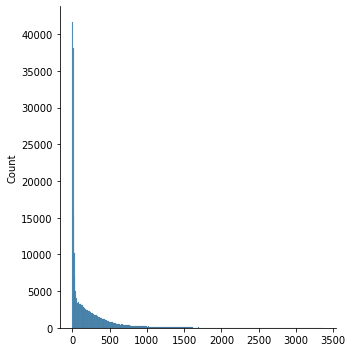

In [15]:
import seaborn as sns

sns.displot(passe[passe>0])

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(20,5))

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

grouped_by_hour = waiting_times.groupby('arrival_hour').agg({'waiting_time':'mean'})
sns.lineplot(x = grouped_by_hour.index, y = grouped_by_hour.values[:,0],ax = ax[0], label = 'avg waiting time')
sns.lineplot(x = np.arange(0,24), y = normalize(hourly_arrival_rate.sum()), label = 'arrival rate norm', ax = ax[1], color = 'orange')
sns.lineplot(x = grouped_by_hour.index, y = normalize(grouped_by_hour.values[:,0]), label = 'avg waiting time norm', ax = ax[1])